In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Estimating Perspective Shift

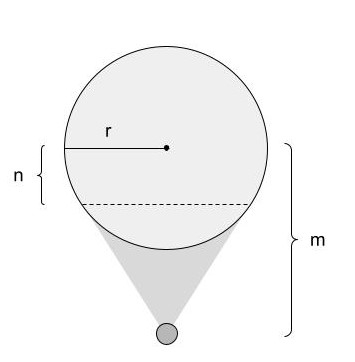

Plane of occlusion offset (relative to center of circular object) as a function of object radius, r, and distance from object center, m:

$$ n = r(1-cos(sin^{-1}(\frac{r}{m}))) $$

In [2]:
def get_n(m, r):
    """calculates plane of occlusion offset as a function of cicrular object radius 
    and distance from object center"""
    n = r*(1-np.cos(np.arcsin(r/m)))
    return n

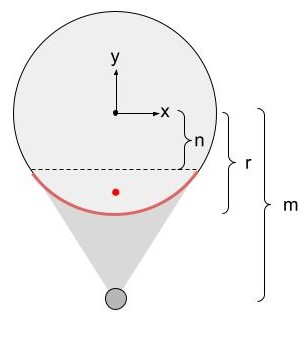

Calculating the "center" (drawn as red dot) of all points lying on the visible surface (red arc):

$$ \mu = [\mu_x, \mu_y ] $$

If reference frame is centered below object:

$$ \mu_{x} = 0 $$

<!-- ## Wrong

Use equation for semicircle to get vertical component: 
$$ y = \sqrt{r^2 - x^2} $$

$$ \mu_{y} = \frac{1}{|x_{y = r} - x_{y = n}|} \int _{x_{y = r}} ^{x_{y = n}} \sqrt{r^2 - x^2} dx $$ 

$$  = \frac{1}{\sqrt{r^2 - n^2}} \int ^{\sqrt{r^2 - n^2}} _{0} \sqrt{r^2 -x^2} dx $$ 

$$  = \frac{1}{\sqrt{r^2 - n^2}} \bigg[ \frac{1}{2} x \sqrt{r^2 - x^2} + r^2 sin^{-1} \bigg(\frac{x}{r} \bigg) \bigg] \bigg\rvert^{\sqrt{r^2 - n^2}}_{0} $$ 
-->
<!-- $$  = \frac{1}{\sqrt{r^2 - n^2}} \bigg[ \frac{1}{2} n \sqrt{r^2 - n^2} + tan^{-1} \bigg(\frac{\sqrt{r^2 - n^2}}{\sqrt{2r^2 - n^2}} \bigg) \bigg]  $$ -->

<!-- $$  = \frac{1}{\sqrt{r^2 - n^2}} \bigg[ \frac{1}{2} n \sqrt{r^2 - n^2} + (r^2 - n^2) sin^{-1} \bigg(\frac{\sqrt{r^2 - n^2}}{r} \bigg) \bigg]  $$ -->


Using mean y coordinate:

$$ \mu_{y} = \frac{1}{\sqrt{r^2-n^2}} \int_0^{\sqrt{r^2-n^2}} \sqrt{r^2 - x^2} dx $$ 


$$  = \frac{1}{\sqrt{r^2 - n^2}} \frac{1}{2} \bigg[  x \sqrt{r^2 - x^2} + r^2 sin^{-1} \bigg(\frac{x}{r} \bigg) \bigg] \bigg\rvert^{\sqrt{r^2 - n^2}}_{0} $$ 


Using the centriod (alternate method):

$$ \mu_y = \frac{ \int _{n} ^{r} 2xy dy}{Segment Area} $$ 


$$ \mu_y = \frac{\int _{n} ^{r} 2y \sqrt{r^2 - y^2} dy}{Segment Area} $$

$$ \mu_y = \frac{ \frac{-2}{3} \bigg{(}r^2 - y^2\bigg{)}^{\frac{3}{2}}  \bigg\rvert^{r}_{n}} { ( \phi r^2 ) - ( nr*sin(\phi) ) }, \phi = \frac{\pi}{2}-sin^{-1} \bigg{(} \frac{n}{r} \bigg{)} $$


In [3]:
def get_mu(m,r):
    """returns offset between circular object center and observed distribution center"""
    n = get_n(m,r)
    phi = (np.pi/2) - np.arcsin(n/r)

#     # Centroid ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     # area = area of pizza slice - area of triangle
#     area = (phi * r**2) - ( n*r*np.sin(phi)) #CORRECT
#     mu_y = ((-2/3)*(r**2 - n**2)**(3/2))/ area 
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #mean y value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    x = np.sqrt(r**2 - n**2)
    high = -(1/np.sqrt(r**2 - n**2)) *(0.5*(x*np.sqrt(r**2 - x**2) + (r**2)*np.arcsin(x/r)))
    x = 0
    low = (1/np.sqrt(r**2 - n**2)) *(0.5*(x*np.sqrt(r**2 - x**2) + (r**2)*np.arcsin(x/r)))
    mu_y = high - low
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    mu_x = 0.0
    mu = np.array([[mu_x, mu_y]])
    return mu
    

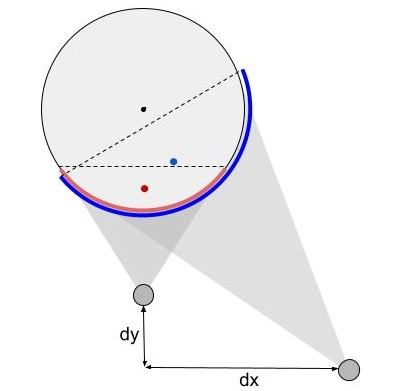

In [343]:
def get_shift(obj_radius, obj_center, dX, ax, draw = False):
    """calculates affect of perspective shift when moving dX relative to feature i"""
    #get distribution center from scan1
    m0 = np.sqrt(obj_center[0]**2 + obj_center[1]**2)    #get distance between obj and X0
    mu0 = get_mu(m0, obj_radius) #+ obj_center
    theta0 = np.arctan2(obj_center[0], obj_center[1])
    rot0 = np.array([[np.cos(theta0), -np.sin(theta0)],
                     [np.sin(theta0), np.cos(theta0)]])
    mu0 = (mu0).dot(rot0) + obj_center
    
    #get distribution center from scan2
    m1 = np.sqrt((obj_center[0] - dX[0])**2 + (obj_center[1] - dX[1])**2 )  #get distance between obj and X1
    mu1 = get_mu(m1, obj_radius) #+ obj_center
    theta1 = np.arctan2(obj_center[0] - dX[0] , obj_center[1] - dX[1])
    #rotation matrix to transform mu1
    rot1 = np.array([[np.cos(theta1), -np.sin(theta1)],
                     [np.sin(theta1), np.cos(theta1)]])
    mu1 = (mu1).dot(rot1) + obj_center    
    shift = mu1 - mu0
    
    #project into compact directions ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #draw line representing ambiguous direction of each distribution
    extended_ang = np.arctan2(obj_center[0], obj_center[1]) + np.pi/2
    rot_extended  = np.array([[np.cos(extended_ang), -np.sin(extended_ang)],
                     [np.sin(extended_ang), np.cos(extended_ang)]])
    rot_compact  = np.array([[np.cos(extended_ang + np.pi/2), -np.sin(extended_ang + np.pi/2)],
                     [np.sin(extended_ang + np.pi/2), np.cos(extended_ang + np.pi/2)]])
    arrow_ends = np.array([[0,.5]]).dot(rot_extended)
    ax.arrow(mu0[0,0], mu0[0,1], arrow_ends[0,0], arrow_ends[0,1],
            head_width = 0.05,  lw = 1, color = 'red')
    ax.arrow(mu0[0,0], mu0[0,1], -arrow_ends[0,0], -arrow_ends[0,1],
            head_width = 0.05,  lw = 1, color = 'red')
    
    #ang between x axis and vector between mu0, mu1
    psi = np.arctan2( mu1[:,1] - mu0[:,1], mu1[:,0] - mu0[:,0]  )
    phi = psi + theta0
    #get distance by which mu1 is offset from the useful direction of mu0
    x = np.sqrt(shift[:,0]**2 + shift[:,1]**2)*np.sin(phi)[0]
    x = np.array([[x[0], 0]])
    
    #draw line projecting mu1 to mu0 axis
    compact = x.dot(rot_extended) #CORRECT
#     print(proj_arr)
    ax.arrow(mu1[0,0], mu1[0,1], compact[0,0], compact[0,1], head_width = 0.0, length_includes_head = True)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    if draw:
        ax.plot(mu0[:,0],mu0[:,1], 'ro')
        ax.plot(mu1[:,0],mu1[:,1], 'bo')
#         ax.plot([dX[0], dX[0] + m1*np.sin(theta1)], [dX[1], dX[1] + m1*np.cos(theta1)]) #verify theta
    return shift, compact

<IPython.core.display.Javascript object>


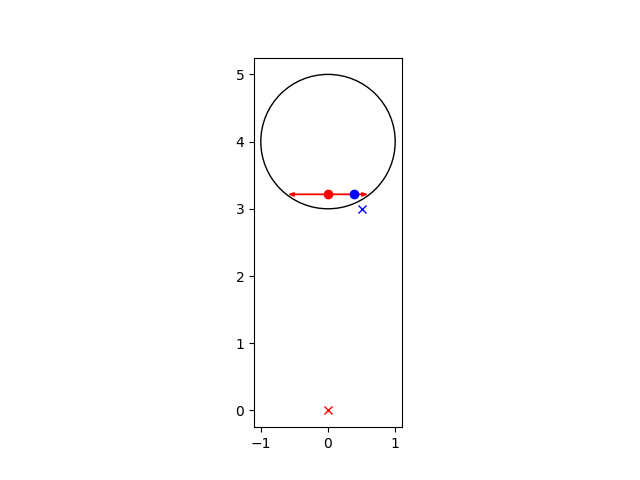

In [354]:
#calculte perspective shift in a single object when moving between two points
fix, ax = plt.subplots()
r = 1
obj = np.array([0,4])
dX = np.array([0.5,  3])

shift, _ = get_shift(r, obj, dX, ax, draw = True)
# print(shift)

X0 = np.array([0,0]) #set to origin
X1 = X0 + dX
ax.set_aspect('equal')
# ax.set_xlim([-5,5])
# ax.set_ylim([-5,5])
circle = plt.Circle(obj,r, fill = False)
ax.add_patch(circle)
ax.plot(X0[0],X0[1], 'rx')
ax.plot(X1[0],X1[1], 'bx')

<IPython.core.display.Javascript object>


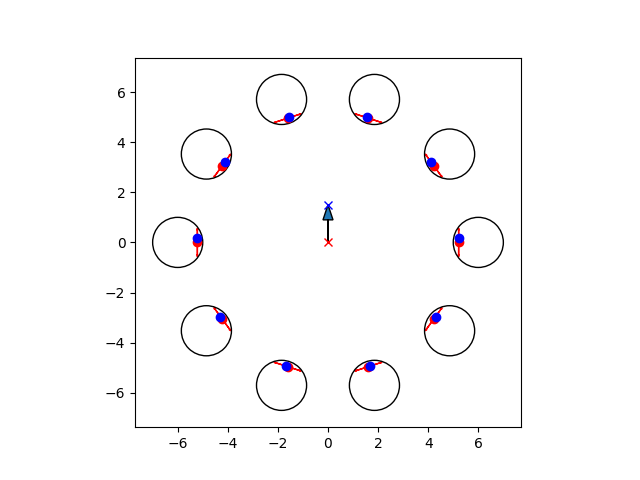


 Mean compact error in distribution centers [ 7.97972799e-18 -1.51332242e-03]
 Sum compact error in distribution centers [ 7.97972799e-17 -1.51332242e-02]


In [364]:
#calculate perspective shift for scene with multiple cylindrical objects

fix, ax = plt.subplots()
# obj_list = np.array([[-3, 2],
#                      [-3, -1.5],
#                      [2, -4],
#                      [1,3],
#                      [2.5, 1],
#                      [-5, -0.6]])
# r_list = np.array([1,0.4,1.5, 0.4, 1., 0.5])

obj_list = np.append(6*np.ones([10,1]), np.zeros([10,1]), axis = 1)
for j in range(np.shape(obj_list)[0]):
    theta = (2*np.pi*j)/np.shape(obj_list)[0]
    rot  = np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])# obj_list = obj_list.dot([])
    obj_list[j] = obj_list[j].dot(rot)
    # print(obj_list)
r_list = 1*np.ones(10)

raw_total = np.zeros(np.shape(obj_list))
compact_total = np.zeros(np.shape(obj_list))

for i, obj in enumerate(obj_list):
    r = r_list[i]
    dX = np.array([0.0,  1.5])
    shift, compact = get_shift(r, obj, dX, ax, draw = True)
    circle = plt.Circle(obj,r, fill = False)
    ax.add_patch(circle)
    raw_total[i] = shift 
    compact_total[i] = compact
    

# print("Raw error contributions from each object: \n" , raw_total)
# print("\nMean (raw) error in distribution centers", np.mean(raw_total, axis = 0))

# print("\n compact errors: \n", compact_total)
print("\n Mean compact error in distribution centers", np.mean(compact_total, axis = 0))
print(" Sum compact error in distribution centers", np.sum(compact_total, axis = 0))


X0 = np.array([0,0])
X1 = X0 + dX
ax.set_aspect('equal')
# ax.set_xlim([-5,5])
# ax.set_ylim([-5,5])
ax.plot(X0[0],X0[1], 'rx')
ax.plot(X1[0],X1[1], 'bx')
ax.arrow(0, 0, X1[0], X1[1], head_width = 0.4, length_includes_head = True, lw = 1)

### Taking the mean of these errors demonstrates the effect of perspective shift BUT this includes contributions from extended (useless) directions

TODO: remove extended distribution axis

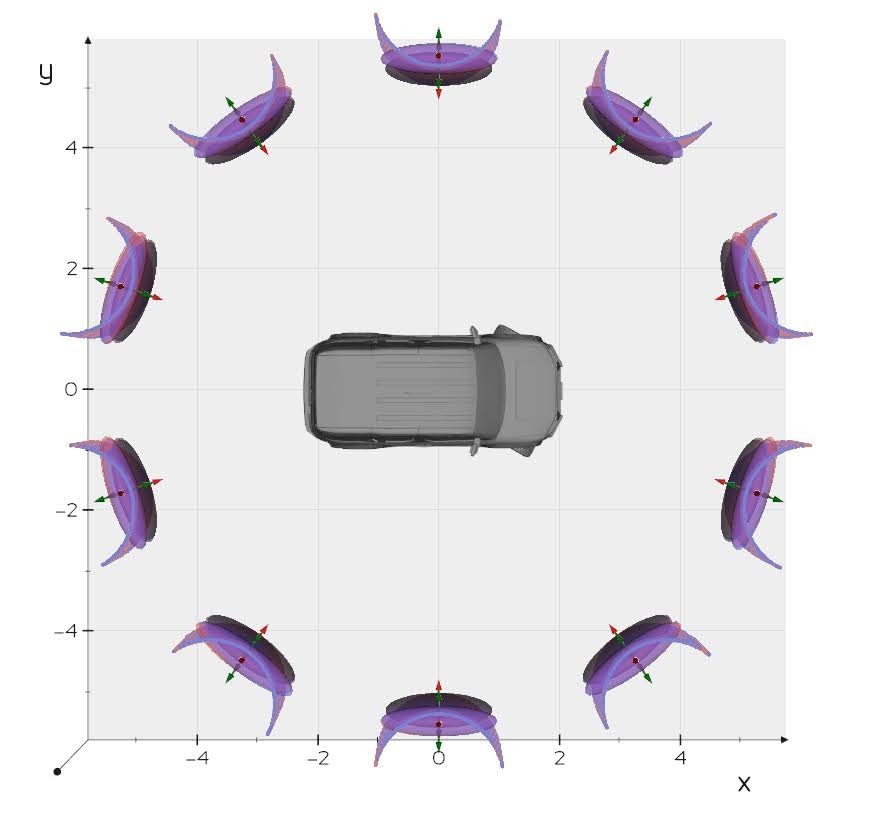

Comparing results to a 3D enviornent of the same geometry...

In [365]:
#Unit Test: Calculate apparent center of single visible surface and draw 
r = 1 #object radius
m = 1.5 #distance from object center

n = get_n(m,r) #plane of occlusion offset
print("Plane of occlusion offset:", n)
mu = get_mu(m,r)
print("Distribution center:", mu)

fig, ax = plt.subplots()
ax.set_aspect('equal')
# ax.set_xlim([-5,5])
# ax.set_ylim([-5,5])
circle = plt.Circle((0,0),r, fill = False)
ax.add_patch(circle)

ax.plot(0, -m, 'bx') #draw observer
ax.plot(0,0,'ko') #draw center of circular object
ax.plot([-r,r], [-n, -n], 'k--') #draw occlusion plane
ax.plot(mu[0,0], mu[0,1], 'ro') #draw apparent center of surface

Plane of occlusion offset: 0.2546440075000701
Distribution center: [[ 0.         -0.80636514]]


<IPython.core.display.Javascript object>

In [366]:
#Unit Test: Verify numerically that get_mu is working correctly
rad = 1
npts = 100

# #Uniform spread of NORMALS from OBSERVER POV  ~~~~~~~~~~~~~~~~~~~~~
x = 2*rad*np.random.rand(npts) - rad
y = -np.sqrt(rad**2 - x**2)
pts1 = np.array([x, y]).T
# pts1 = pts1[pts1[:,1] < -.5834] #move occlusion plane
mu1 = np.mean(pts1, axis = 0)
print(mu1)
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Uniform spread about SURFACE OF ARC ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
roll = np.pi*np.random.rand(npts) + np.pi/2
pts2 = np.array([rad*np.sin(roll), rad*np.cos(roll)]).T
# pts2 = pts2[pts2[:,1] < -.5834] #move occlusion plane
mu2 = np.mean(pts2, axis = 0)
print(mu2)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, ax = plt.subplots(1,2)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_xlim([-1.5,1.5])
ax[1].set_xlim([-1.5,1.5])
ax[0].set_ylim([-1.5,0.5])
ax[1].set_ylim([-1.5,0.5])

ax[0].set_title("uniform horizontal distribution")
ax[1].set_title("uniform distribution across object surface")
ax[0].plot(pts1[:,0],pts1[:,1], 'b.', ms = 3)
ax[1].plot(pts2[:,0] ,pts2[:,1], 'r.', ms = 3)

ax[0].plot(mu1[0],mu1[1], 'bx')
ax[1].plot(mu2[0],mu2[1], 'rx')

[-0.02580803 -0.77944044]
[-0.03993446 -0.63514447]


<IPython.core.display.Javascript object>

# Questions

#### Even sampling in x direction vs even sampling across surface of object 
This is similar to how a lidar unit records (at sufficient distance)

#### How do determine radius of each object

Can only use distribution lengths if entire object is contained within a single voxel

Use 3rd moment?

#### Using centroid
Does not line up with MC results, however, logically we know that the measured surfaces are actually representative of physical objects that are most likely NOT convex